In [16]:
import numpy as np
import ctypes as c
import numpy.ctypeslib as npc
import matplotlib.pyplot as plt
import os

import time

import lyncs_io as io

In [2]:
def pragma_test():   
    lib_path = "/home/ben/Work/gluon-prop/libgprop.so"
        
    c.cdll.LoadLibrary(lib_path)
    
    LIB = c.CDLL(lib_path)
    
    LIB.pragma_test.argtypes = None
    LIB.pragma_test.restype = c.c_int
    
    return LIB.pragma_test()

In [3]:
pragma_test()

4

In [4]:
class c_double_complex(c.Structure): 
    """Returns a double complex C structure."""
    _fields_ = [("real", c.c_double),("imag", c.c_double)]
    @property
    def value(self):
        return self.real+1j*self.imag

class GluonField(c.Structure):
    """Creates a struct to match gluon_field C structure."""

    _fields_ = [('Nt', c.c_int),
                ('Ns', c.c_int),
                ('Nd', c.c_int),
                ('Nc', c.c_int),
                ('A', c.POINTER(c_double_complex))]

In [5]:
def get_prop(gluon_field, mu, nu, a, b, t, y):
        """Applies SU(N) gauge transformation to the lattice."""
    
        #script_dir = os.path.abspath(os.path.dirname(__file__))
        #lib_path = os.path.join(script_dir, "libgprop.so")
        
        lib_path = "/home/ben/Work/gluon-prop/libgprop.so"
        
        c.cdll.LoadLibrary(lib_path)
    
        LIB = c.CDLL(lib_path)
    
        LIB.gluon_prop.argtypes = [c.POINTER(GluonField),
                                   c.c_int,
                                   c.c_int,
                                   c.c_int,
                                   c.c_int,
                                   c.c_int,
                                   npc.ndpointer(np.int32, ndim=1, flags="C_CONTIGUOUS")]
    
        LIB.gluon_prop.restype = c_double_complex
    
        return LIB.gluon_prop(gluon_field, mu, nu, a, b, t, y).value
        
def get_scalar_D(gluon_field, t, D):
    """Calculates the scalar field propagator for the lattice."""
    
    lib_path = "/home/ben/Work/gluon-prop/libgprop.so"
        
    c.cdll.LoadLibrary(lib_path)
    
    LIB = c.CDLL(lib_path)
    
    LIB.calc_scalar_D.argtypes = [c.POINTER(GluonField),
                                  c.c_int,
                                  npc.ndpointer(np.complex128, ndim=None, flags="C_CONTIGUOUS")]
    
    LIB.calc_scalar_D.restype = None
    
    return LIB.calc_scalar_D(gluon_field, t, D)

In [6]:
data = io.load("/home/ben/Work/gauge_confs/8x32/Gen2l_8x32n1",format="openqcd")
#data = np.array([3.2+1.6j])

In [7]:
gf = GluonField()
gf.Nt = (c.c_int)(8)
gf.Ns = (c.c_int)(32)
gf.Nd = (c.c_int)(4)
gf.Nc = (c.c_int)(3)
gf.A = data.ctypes.data_as(c.POINTER(c_double_complex))

In [8]:
y = np.array((1,4,2,5),dtype=np.int32)

mu, nu, a, b = (0,0,0,0)
t = 1

result = get_prop(gf,mu, nu, a, b, t, y)
result

(3.4618760571777535e-05+0j)

In [9]:
D = np.zeros((gf.Ns,gf.Ns,gf.Ns), dtype='complex128')

start = time.time()
get_scalar_D(gf,0,D)
end = time.time()

print(end-start)

1125.018891096115


In [10]:
D

array([[[ 1.16934373e+00+1.55517604e-03j,
          1.67492728e-03+2.40728210e-04j,
          1.90489270e-04-4.53316555e-04j, ...,
         -6.61084654e-04+1.02681983e-04j,
          1.90489270e-04-4.53316555e-04j,
          1.67492728e-03+2.40728210e-04j],
        [ 2.66831712e-04-2.14611221e-04j,
          7.45081242e-04-3.13070681e-04j,
          1.67382970e-03+3.64099557e-04j, ...,
         -1.41229220e-03+4.25636573e-05j,
         -6.48475369e-04+6.94660044e-05j,
          9.10306685e-04+4.47818249e-04j],
        [-7.07641011e-04+3.63088507e-05j,
         -2.95332649e-04+1.97520260e-05j,
         -1.81519034e-03+8.04230388e-04j, ...,
          6.00836510e-04-2.54886488e-04j,
         -1.25732007e-03-1.45210316e-04j,
         -9.68280675e-04-9.48635864e-04j],
        ...,
        [-1.09730852e-03-1.20173309e-03j,
         -8.48781326e-05-1.30314305e-03j,
          1.47441112e-03-1.88965778e-03j, ...,
          9.61791521e-04-1.79015747e-05j,
          5.06605334e-04+1.16528817e-04j

In [12]:
copyD = np.copy(D)

In [15]:
fftD = np.fft.fftn(copyD)
fftD

array([[[1.44349696-0.17809255j, 1.33550461+0.05182758j,
         1.39952107-0.12234488j, ..., 1.21826335+0.06429161j,
         1.39952107-0.12234488j, 1.33550461+0.05182758j],
        [1.089953  -0.0634717j , 1.42842386+0.03763098j,
         1.09015513+0.01858619j, ..., 1.17883778-0.17429098j,
         1.10238541-0.04811626j, 1.557775  -0.15897274j],
        [0.9140474 +0.04505106j, 1.41681098+0.00909731j,
         0.8652567 -0.04105886j, ..., 0.98116881-0.19964142j,
         1.14578163-0.0668713j , 1.08308247+0.14259506j],
        ...,
        [1.10065306-0.42615993j, 1.00830182+0.04680118j,
         1.19545952+0.31523173j, ..., 1.42025793+0.0128059j ,
         1.01235272-0.09347213j, 1.38668433+0.05853784j],
        [0.9140474 +0.04505106j, 1.08308247+0.14259506j,
         1.14578163-0.0668713j , ..., 1.15393376+0.01276644j,
         0.8652567 -0.04105886j, 1.41681098+0.00909731j],
        [1.089953  -0.0634717j , 1.557775  -0.15897274j,
         1.10238541-0.04811626j, ..., 1.46643

In [20]:
results = []

start = time.time()

t = 0

for qi in range(32):
    for qj in range(32):
        for qk in range(32):                
            results.append([np.array((0,qi,qj,qk)),fftD[qi,qj,qk]])

results_cleaned = []

def q_wilson(q_hat,a=1):
    return (2/a)*np.sin(np.asarray(q_hat)*a/2)

for result in results:
    if np.all(result[0] == 0):
        results_cleaned.append([0,result[1]*2/((gf.Nc**2-1)*gf.Nd*32*32*32*8)])
    else:
        results_cleaned.append([np.linalg.norm(q_wilson(result[0])),result[1]*2/((gf.Nc**2-1)*(gf.Nd-1)*32*32*32*8)])

results_cleaned = np.asarray(results_cleaned)

In [33]:
q = results_cleaned[:,0]
D = results_cleaned[:,1]

Text(0, 0.5, '$q^2a^2D(q^2)$')

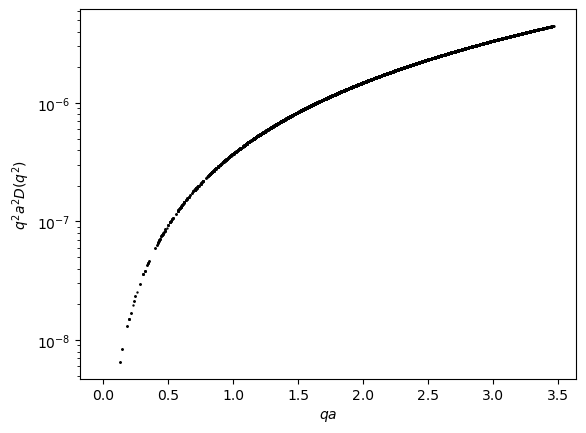

In [34]:
plt.scatter(q,np.abs(q**2*D.mean(axis=0)),s=0.5,c='k')
plt.yscale('log')
plt.xlabel(r'$qa$')
plt.ylabel(r'$q^2a^2D(q^2)$')